# PHYS305 project: Modelling Lévy Flights and Optimal Search Strategies in Biological Systems

Simulate and analyse Lévy flight and Brownian motion search strategies in order to compare their efficiency in locating randomly distributed targets, with applications in biological foraging, robotics, and ecological modelling.

Project objectives:

- Simulate Lévy flight dynamics
- Compare Lévy flights to Brownian motion in foraging efficiency and target search.
- Analyse real-world biological relevance, such as animal movement, human search behaviour, and microbial exploration.
- Explore the effect of environmental conditions (barriers, resources, obstacles) on the efficiency of different search strategies.
- Visualize and analyse search efficiency using Monte Carlo simulations.

The code and examples below are a starting point for further exploration.

*For enquiries, e-mail **Prof. Costas Andreopoulos** <c.andreopoulos @ cern.ch>*


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from enum import Enum

%matplotlib inline

In [2]:
class Environment:
    """
    """
    def __init__(self, xrange, yrange, obstacles=None):
        """
        Inputs:
        - xrange:
        - yrange:
        - obstacle: A function of position, a numpy vector (x,y), that returns True for (x,y) positions that cannot be occupied
        """
        self._xrange = xrange
        self._yrange = yrange
        self._obstacles = obstacles
    
    @property
    def xrange(self):
        """ 
        """
        return self._xrange

    @property
    def yrange(self):
        """ 
        """
        return self._yrange

    def is_allowed_position(self,position):
        """ 
        """
        x = position[0]
        y = position[1]
        out_of_range = x < self._xrange[0] or x > self._xrange[1] or y < self._yrange[0] or y > self._yrange[1]
        in_obstacle  = False if self._obstacles == None else self._obstacles(position)
        allowed = not out_of_range and not in_obstacle        
        return allowed

    def trace_environment_map(self, nhits, ax):
        rng = np.random.default_rng()
        xsamples = self.xrange[0] + rng.random(nhits) * (self.xrange[1]-self.xrange[0])
        ysamples = self.yrange[0] + rng.random(nhits) * (self.yrange[1]-self.yrange[0])
        positions = np.column_stack((xsamples,ysamples))
        allowed_positions_mask = np.array([self.is_allowed_position(p) for p in positions])
        obstacle_positions = positions[~allowed_positions_mask]
        obstacle_found = obstacle_positions.size > 0
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        if obstacle_found:
            ax.scatter(obstacle_positions[:,0],obstacle_positions[:,1],color='black',s=1)
        ax.set_xlim(self.xrange[0],self.xrange[1])
        ax.set_ylim(self.yrange[0],self.yrange[1])

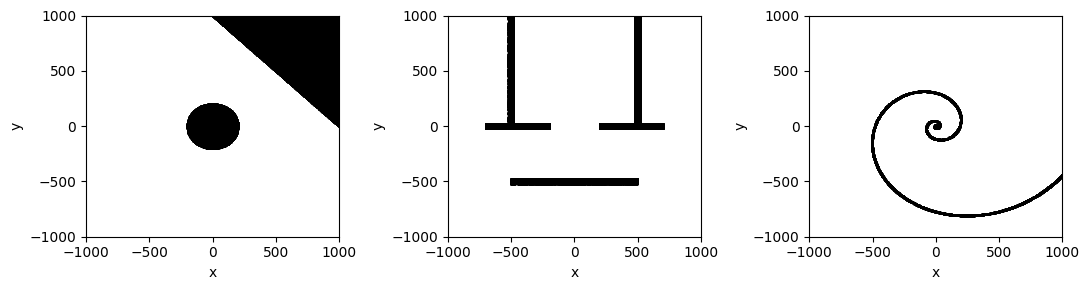

In [40]:
# Define and test a few instances of the Environment class

def avoid_circular_area_in_centre_or_top_right_corner(pos):
    r = np.sqrt(np.sum(pos**2))
    if r < 200:
        return True
    if pos[0] + pos[1] > 1000:
        return True
    return False    

def avoid_walls(pos):
    wall_width = 20
    if np.abs(pos[0]-500) < wall_width and pos[1] > 0:
        return True
    if np.abs(pos[0]+500) < wall_width and pos[1] > 0:
        return True
    if pos[0] > -700 and pos[0] < -200 and np.abs(pos[1]) < wall_width:
        return True
    if pos[0] >  200 and pos[0] <  700 and np.abs(pos[1]) < wall_width:
        return True
    if pos[0] > -500 and pos[0] <  500 and np.abs(pos[1]+500) < wall_width:
        return True
    return False    

def avoid_walls_in_logarithmic_spiral(pos):
    theta = np.arctan2(pos[1],pos[0])
    r = np.sqrt(np.sum(pos**2))
    a = 0.1 # scale
    b = 0.3 # spiral tightness
    d = 2.0 # thickness of spiral
    max_turns = 6
    for k in range(-max_turns, max_turns + 1):
        theta_k = theta + 2 * np.pi * k    # Consider multiple turns
        r_s = a * np.exp(b * theta_k)      # Spiral radius at current turn        
        if(np.abs(r-r_s) < d): 
            return True

    return False    

xrange = np.array([-1000,1000])
yrange = np.array([-1000,1000])

environment_1 = Environment(xrange, yrange, avoid_circular_area_in_centre_or_top_right_corner)
environment_2 = Environment(xrange, yrange, avoid_walls)
environment_3 = Environment(xrange, yrange, avoid_walls_in_logarithmic_spiral)

fig = plt.figure(figsize=(11, 3))
gs = gridspec.GridSpec(1,3, width_ratios=[1, 1, 1], figure=fig)
axsL = fig.add_subplot(gs[0,0]) # left
axsC = fig.add_subplot(gs[0,1]) # centre
axsR = fig.add_subplot(gs[0,2]) # right

environment_1.trace_environment_map(1000000,axsL)
environment_2.trace_environment_map(1000000,axsC)
environment_3.trace_environment_map(1000000,axsR)
plt.tight_layout()
plt.show()

In [41]:
class PreyMotion(Enum):
    NONE                = 0
    BROWNIAN_PERPETUAL  = 1
    BROWNIAN_RESTRICTED = 2

class Prey:
    """
    """
    def __init__(self, environment, initial_position, motion_type = PreyMotion.NONE, motion_params = None):

        self._environment = environment
        self._trajectory = []        
        self._trajectory.append(initial_position)
        self._initial_position = initial_position
        self._current_position = initial_position
        self._motion_type      = motion_type
        self._motion_params    = motion_params
        
    @property
    def trajectory(self):
        """ 
        Trajectory of the prey. 
        Returns the position (x,y) at each time step of the simulation, as an array with shape (nsteps,2)
        """
        return np.array(self._trajectory)

    @property
    def current_position(self):
        """ 
        Current position of the prey.
        Returns (x,y) position in m, as a numpy array with shape (2,)
        """
        return self._current_position

    @property
    def motion_type(self):
        """ 
        Returns the type of prey motion 
        """
        return self._motion_type

    @property
    def motion_params(self):
        """ 
        Returns parameters controlling the prey motion.
        """
        return self._motion_params

    def __str__(self):
        out = ""
        if self.motion_type == PreyMotion.NONE:
            out = "- Stationary prey"            
        elif self.motion_type == PreyMotion.BROWNIAN_PERPETUAL:
            out = f"- Prey in perpetual Brownian random walk with settings: {self.motion_params}"
        elif self.motion_type == PreyMotion.BROWNIAN_RESTRICTED:
            out = f"- Prey in restricted Brownian random walk with settings: {self.motion_params}"
        out += f" - Current position {self.current_position} m: "
        return out
        
    def simulate_step(self):
        """
        """
        if self.motion_type == PreyMotion.NONE:
            return

        while True:        
            rng = np.random.default_rng()
            proposed_step = np.zeros(2)        

            if self.motion_type == PreyMotion.BROWNIAN_PERPETUAL or self.motion_type == PreyMotion.BROWNIAN_RESTRICTED:
                mean = self.motion_params["step-mean"]
                cov  = self.motion_params["step-covariance"]            
                proposed_step = rng.multivariate_normal(mean,cov)
            
            proposed_position = self._current_position + proposed_step
            
            allowed = self._environment.is_allowed_position(proposed_position)
            if not allowed:
                continue # try again
            
            if self.motion_type == PreyMotion.BROWNIAN_RESTRICTED:
                rmax = self.motion_params["max-distance"]            
                r = np.sqrt(np.sum(proposed_position**2))
                too_far = r > rmax
                if too_far:
                    continue # try again
                    
            self._current_position = proposed_position        
            self._trajectory.append(proposed_position)
            break
        
    def plot_trajectory(self,ax):
        ax.plot(self.trajectory[:,0],self.trajectory[:,1],linestyle='-')
        target = plt.Circle(self.trajectory[0],10,color='red',fill=True,linewidth=2)
        ax.add_patch(target)


In [5]:
prey_motion_params_1 = {"step-mean": np.array([0,0]), "step-covariance": np.array([[3,0],[0,3]]) }
prey_motion_params_2 = {"step-mean": np.array([0,0]), "step-covariance": np.array([[5,0],[0,5]]) }

prey_0 = Prey(environment_1,[-800,-750])
prey_1 = Prey(environment_1,[500, 250], PreyMotion.BROWNIAN_PERPETUAL, prey_motion_params_1)
prey_2 = Prey(environment_1,[  0, 550], PreyMotion.BROWNIAN_PERPETUAL, prey_motion_params_2)

print(prey_0)
print(prey_1)
print(prey_2)

- Stationary prey - Current position [-800, -750] m: 
- Prey in perpetual Brownian random walk with settings: {'step-mean': array([0, 0]), 'step-covariance': array([[3, 0],
       [0, 3]])} - Current position [500, 250] m: 
- Prey in perpetual Brownian random walk with settings: {'step-mean': array([0, 0]), 'step-covariance': array([[5, 0],
       [0, 5]])} - Current position [0, 550] m: 


In [6]:

class PredatorStrategy(Enum):
    BROWNIAN    = 1
    LEVY_FLIGHT = 2

class Predator:
    """
    """
    
    def __init__(self, environment, initial_position, strategy, strategy_params):
        """
        """
        self._environment      = environment
        self._initial_position = initial_position
        self._current_position = initial_position
        self._strategy         = strategy
        self._strategy_params  = strategy_params

        self._trajectory  = []
        self._trajectory.append(initial_position)

    @property
    def trajectory(self):
        """ 
        Predator trajectory. 
        Returns the position (x,y) at each time step of the simulation, as an array with shape (nsteps,2)
        """
        return np.array(self._trajectory)

    @property
    def current_position(self):
        return self._current_position
    
    def simulate_step(self):        
            
        rng = np.random.default_rng()

        while True:            
            proposed_step = np.zeros(2)        

            if self._strategy == PredatorStrategy.BROWNIAN:
                mean = self._strategy_params["step-mean"]
                cov  = self._strategy_params["step-covariance"]            
                proposed_step = rng.multivariate_normal(mean,cov)
            
            if self._strategy == PredatorStrategy.LEVY_FLIGHT:
                step_length = rng.pareto(2) * 10.
                # Generate random direction (uniform in [0, 2π])
                theta = 2*np.pi * rng.uniform()
                # Compute step components
                proposed_step[0] = step_length * np.cos(theta)
                proposed_step[1] = step_length * np.sin(theta)

            proposed_position = self._current_position + proposed_step
            
            allowed = self._environment.is_allowed_position(proposed_position)
            if not allowed:
                continue # try again
                                
            self._current_position = proposed_position        
            self._trajectory.append(proposed_position)
            break

    def plot_trajectory(self,ax):
        ax.plot(self.trajectory[:,0],self.trajectory[:,1],linestyle='-')
        target = plt.Circle(self.trajectory[0],20,color='black',fill=True,linewidth=2)
        ax.add_patch(target)

In [7]:
predator_initial_position = np.array([0,-750])
# predator_strategy = PredatorStrategy.BROWNIAN
# strategy_params = {"step-mean": np.array([0,0]), "step-covariance": np.array([[20,0],[0,20]]) }
predator_strategy = PredatorStrategy.LEVY_FLIGHT
strategy_params = {}

predator_0 = Predator(environment_1, predator_initial_position, predator_strategy, strategy_params)

In [12]:
class Search:
    """
    """
    
    def __init__(self, environment, list_of_targets, list_of_predators):
        """
        """
        self._environment       = environment
        self._list_of_preys     = list_of_preys
        self._list_of_predators = list_of_predators

    def simulate(self, nsteps_max):
        success = False
        for _ in range(nsteps_max):
            self.simulate_step()            
            for predator in self._list_of_predators:
                for prey in self._list_of_preys:
                    d = np.sqrt(np.sum((predator.current_position-prey.current_position)**2))
                    if d <= 1:
                        success = True
                        break
        return success
        
    def simulate_step(self):        
        for prey in self._list_of_preys:
            prey.simulate_step()
        for predator in self._list_of_predators:
            predator.simulate_step()
            
    def plot_trajectories_on_search_environment_map(self, ax):
        self._environment.trace_environment_map(1000000,ax)
        for prey in self._list_of_preys:
            prey.plot_trajectory(ax)            
        for predator in self._list_of_predators:
            predator.plot_trajectory(ax)            

False


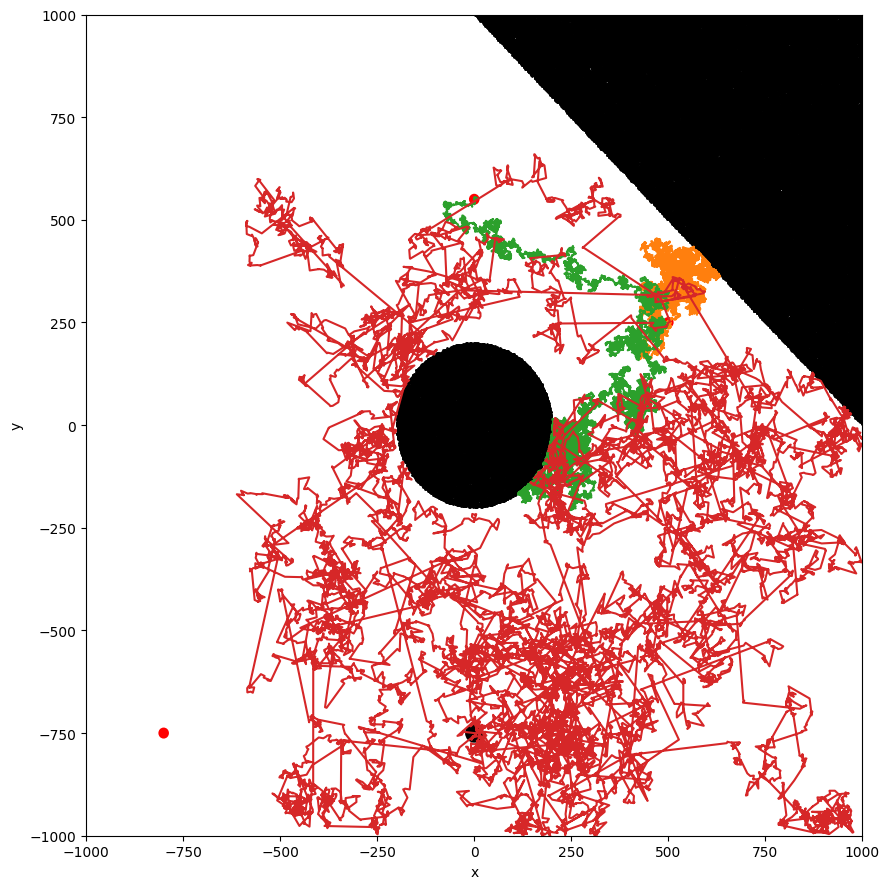

In [13]:
list_of_preys = [prey_0, prey_1, prey_2]
list_of_predators = [predator_0]

search = Search(environment_1, list_of_preys, list_of_predators)

success = search.simulate(10000)
print(success)

fig = plt.figure(figsize=(9, 9))
gs = gridspec.GridSpec(1,1, figure=fig)
ax = fig.add_subplot(gs[0,0])
search.plot_trajectories_on_search_environment_map(ax)
plt.tight_layout()
plt.show()
